# 2D MRF Subspace Reconstruction with Toeplitz Embedding (In-Vivo Data)

This demo will be based on Sigpy. We will start by loading the relvant libraries and data. Here are the data specs:   
- 600 TRs
- 16-channel head coil
- 32 spiral interleaves were used in a repeating order (TR1 = interleave1, ... TR32 = interleave32, TR33 = interleave1)
- 4 subspace basis vectors
- 1000 pts per spiral  
- 2 microsecond dwell time 

More details are found in:   
Cao, X., Liao, C., Wang, Z., Chen, Y., Ye, H., He, H., & Zhong, J. (2016). *Robust sliding-window reconstruction for Accelerating the acquisition of MR fingerprinting*. In Magnetic Resonance in Medicine (Vol. 78, Issue 4, pp. 1579–1588). Wiley. https://doi.org/10.1002/mrm.26521

In [2]:
import numpy as np
import sigpy as sp
import matplotlib.pyplot as plt
import time
import os
from subspace_linops import A_subspace

# GPU Usage
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
device_idx = 0 # Use -1 for CPU
device = sp.Device(device_idx)
mvd = lambda x : sp.to_device(x, device)
mvc = lambda x : sp.to_device(x, sp.cpu_device)
xp = device.xp

# Load MR data
ksp = np.load('data/ksp.npy') # Raw k-space data
trj = np.load('data/trj.npy') # Trajectory
dcf = np.load('data/dcf.npy') # Density compensation
phi = np.load('data/phi.npy') # Subspace basis
mps = np.load('data/mps.npy') # Sensitivity maps

# Show dimensions
print(f'ksp shape = {ksp.shape}')
print(f'trj shape = {trj.shape}')
print(f'dcf shape = {dcf.shape}')
print(f'phi shape = {phi.shape}')
print(f'mps shape = {mps.shape}')

ksp shape = (16, 1000, 1, 600)
trj shape = (1000, 1, 600, 2)
dcf shape = (1000, 1, 600)
phi shape = (4, 600)
mps shape = (16, 200, 200)


## Reconstruction 

We will run 10 Conjugate Gradient iterations with and without the use of toeplitz structure. We expect that toeplitz will speed up the reconstruction, without changing the image quality.

In [3]:
# Make linops
y = np.sqrt(dcf) * ksp
with device:
    sqrt_dcf_gpu = xp.sqrt(mvd(dcf))
    trj_gpu = mvd(trj)
    phi_gpu = mvd(phi)
    mps_gpu = mvd(mps)
A = A_subspace(trj_gpu, phi_gpu, mps_gpu, sqrt_dcf_gpu, fast_AHA=False)
A_toep = A_subspace(trj_gpu, phi_gpu, mps_gpu, sqrt_dcf_gpu, fast_AHA=True)

# Recon
start = time.perf_counter()
coeffs = sp.app.LinearLeastSquares(
        A=A,
        y=y,
        x=A.H * y,
        max_iter=10,
        solver='ConjugateGradient',
        show_pbar=True).run()
stop = time.perf_counter()
print(f'Standard Recon Took {stop-start:.3f}s')

# Toeplitz Recon
start = time.perf_counter()
coeffs_toep = sp.app.LinearLeastSquares(
        A=A_toep,
        y=y,
        x=A.H * y,
        max_iter=10,
        solver='ConjugateGradient',
        show_pbar=True).run()
stop = time.perf_counter()
print(f'Toeplitz Recon Took {stop-start:.3f}s')


Calculating Toeplitz Embeddings
Time = 0.387s


LinearLeastSquares: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it, resid=1.55E-17]


Standard Recon Took 19.458s


LinearLeastSquares: 100%|██████████| 10/10 [00:01<00:00,  7.94it/s, resid=1.54E-17]

Toeplitz Recon Took 3.020s


And here are both subspace reconstructions. As we can see, there is virtually no  difference!

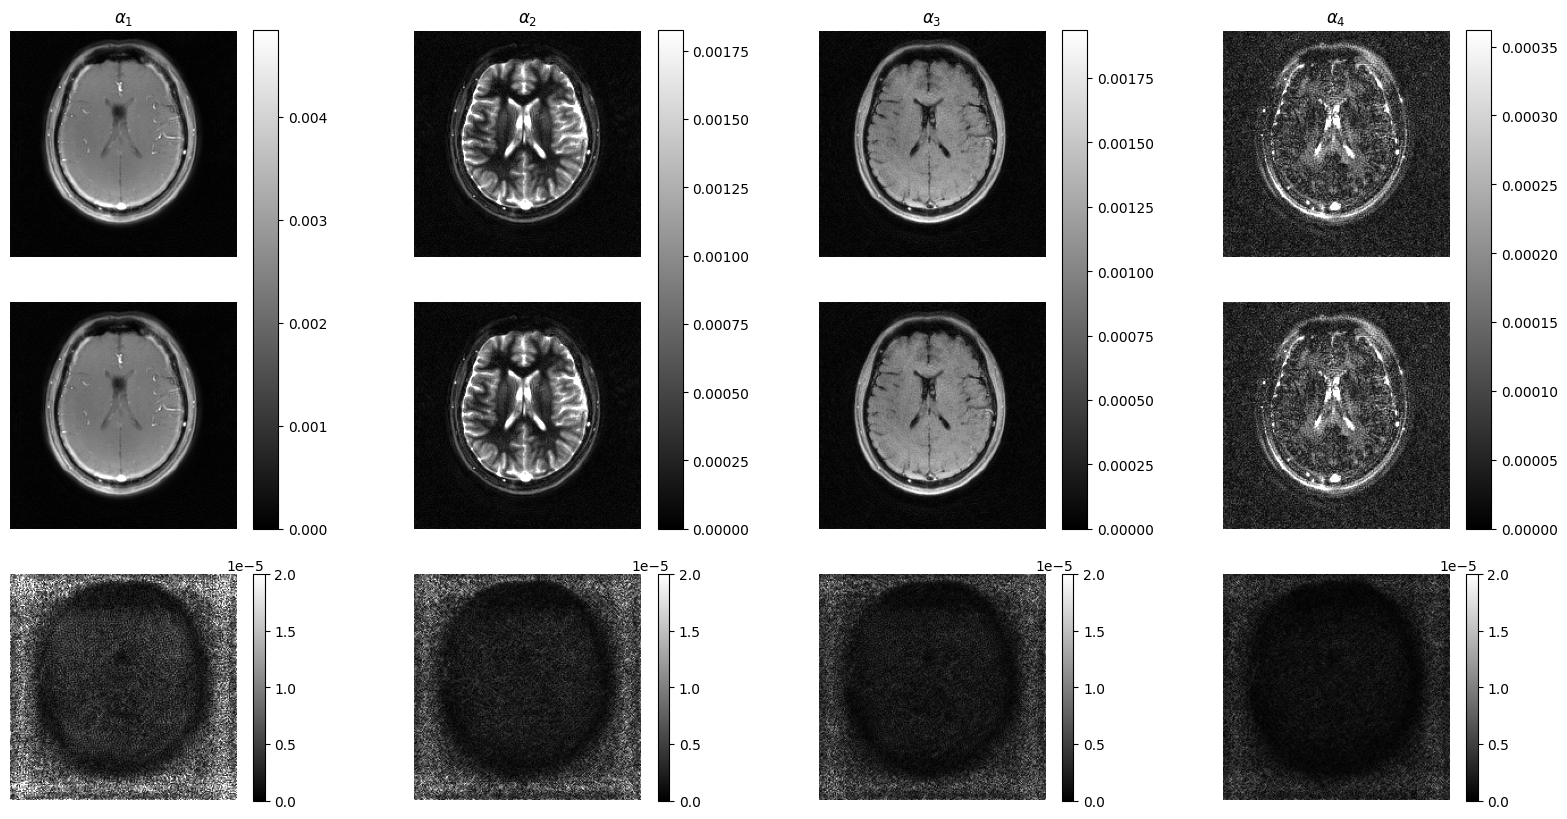

In [4]:
fig, axs = plt.subplots(3, 4, figsize=(20, 10))
for i in range(phi.shape[0]):

    # Regular coefficient
    img = np.abs(coeffs[i])[::-1, ::-1].T
    vmax = np.median(img) + 4 * np.std(img)
    im = axs[0, i].imshow(img, vmin=0, vmax=vmax, cmap='gray')
    axs[0, i].set_title(r'$\alpha_{{{}}}$'.format(i+1))
    axs[0, i].axis('off')

    # Toeplitz coefficient
    img = np.abs(coeffs_toep[i])[::-1, ::-1].T
    vmax = np.median(img) + 4 * np.std(img)
    im = axs[1, i].imshow(img, vmin=0, vmax=vmax, cmap='gray')
    axs[1, i].axis('off')
    fig.colorbar(im, ax=axs[:2, i])

    # Difference
    img = np.abs(coeffs_toep[i] - coeffs[i])[::-1, ::-1].T
    im = axs[2, i].imshow(img, vmin=0, vmax=2e-5, cmap='gray')
    axs[2, i].axis('off')
    fig.colorbar(im, ax=axs[2, i])
